In [20]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/blood-cells/DATASET/Rouleax Red blood cells/cropped1452_r02_c03.jpg
/kaggle/input/blood-cells/DATASET/Rouleax Red blood cells/cropped1369_r02_c00.jpg
/kaggle/input/blood-cells/DATASET/Rouleax Red blood cells/cropped2951_r00_c02.jpg
/kaggle/input/blood-cells/DATASET/Rouleax Red blood cells/cropped549_r01_c00.jpg
/kaggle/input/blood-cells/DATASET/Rouleax Red blood cells/cropped195_r00_c02.jpg
/kaggle/input/blood-cells/DATASET/Rouleax Red blood cells/cropped879_r03_c02.jpg
/kaggle/input/blood-cells/DATASET/Rouleax Red blood cells/cropped1286_r01_c01.jpg
/kaggle/input/blood-cells/DATASET/Rouleax Red blood cells/cropped1122_r00_c01.jpg
/kaggle/input/blood-cells/DATASET/Rouleax Red blood cells/cropped2035_r03_c02.jpg
/kaggle/input/blood-cells/DATASET/Rouleax Red blood cells/cropped170_r02_c01.jpg
/kaggle/input/blood-cells/DATASET/Rouleax Red blood cells/cropped1793_r03_c00.jpg
/kaggle/input/blood-cells/DATASET/Rouleax Red blood cells/cropped1751_r00_c02.jpg
/kaggle/input/blood-

In [21]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Add, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.regularizers import l2
from sklearn import model_selection
import cv2
import matplotlib.pyplot as plt

In [22]:
# Load the dataset
path = r"/kaggle/input/blood-cells/DATASET"
data = tf.keras.utils.image_dataset_from_directory(directory=path, image_size=(128, 128), batch_size=32)

Found 6088 files belonging to 2 classes.


In [23]:
class_names = data.class_names
label_map = {m: n for m, n in zip(np.arange(len(class_names)), class_names)}


In [24]:
datagen = ImageDataGenerator(
    rotation_range=10,        
    width_shift_range=0.1,    
    height_shift_range=0.1,        
    horizontal_flip=True,     
    fill_mode='nearest'
)

In [25]:
# Function to apply image sharpening using Laplace filter
def sharpen_image(image):
    image = image.astype(np.uint8)
    laplacian_filter = cv2.Laplacian(image, cv2.CV_64F)
    sharpened = cv2.convertScaleAbs(image - laplacian_filter)
    return sharpened

In [26]:

# Function to apply data augmentation and record the type of augmentation
def augment_images_with_labels(images, labels):
    images_aug = np.empty_like(images)
    augmentations = []
    
    for i, img in enumerate(images):
        img = img.numpy()  # Convert to NumPy array
        original_img = img.copy()  # Save the original image to compare

        img = sharpen_image(img)  # Apply sharpening
        
        # Apply augmentation
        params = datagen.get_random_transform(img.shape)
        img = datagen.apply_transform(img, params)

        images_aug[i] = img
        
        # Record the applied augmentations
        aug_type = []
        if params['theta'] != 0:
            aug_type.append('Rotation')
        if params['tx'] != 0 or params['ty'] != 0:
            aug_type.append('Shift')
        if params['zx'] != 1 or params['zy'] != 1:
            aug_type.append('Zoom')
        if params['flip_horizontal'] or params['flip_vertical']:
            aug_type.append('Flip')
        
        augmentations.append(', '.join(aug_type) if aug_type else 'None')
    
    # Convert labels to the correct dtype before returning
    return tf.convert_to_tensor(images_aug, dtype=tf.float32), tf.convert_to_tensor(labels, dtype=tf.int32), tf.convert_to_tensor(augmentations, dtype=tf.string)


In [27]:
def display_normal_and_sharpened_images(data, label_map, n_samples=1):
    for images, labels in data.take(1):
        for i in range(len(label_map)):
            img = images[labels == i][0].numpy().astype(np.uint8)
            sharpened_img = sharpen_image(img)
            
            plt.figure(figsize=(10, 4))
            plt.subplot(1, 2, 1)
            plt.imshow(img)
            plt.title(f"Normal Image - {label_map[i]}")
            
            plt.subplot(1, 2, 2)
            plt.imshow(sharpened_img)
            plt.title(f"Sharpened Image - {label_map[i]}")
            
            plt.show()


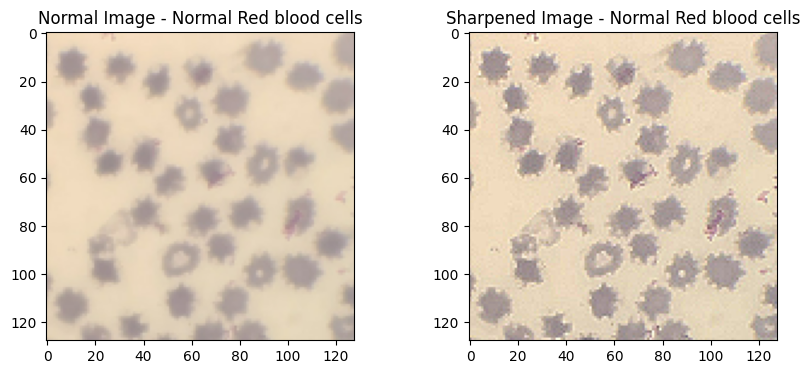

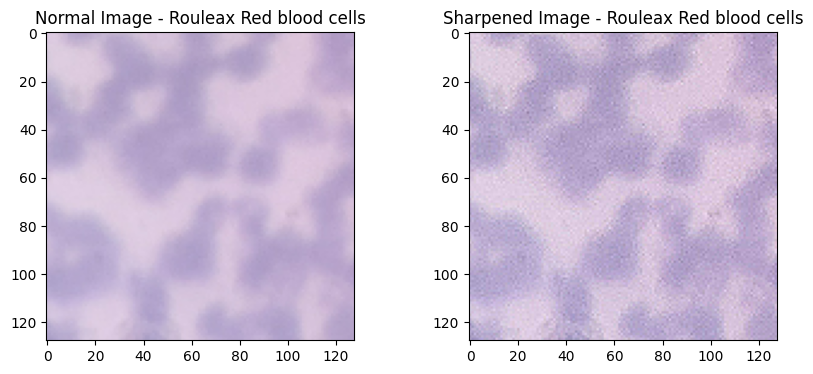

In [28]:
display_normal_and_sharpened_images(data, label_map)

In [29]:
augmented_data = data.map(lambda x, y: tf.py_function(augment_images_with_labels, [x, y], [tf.float32, tf.int32, tf.string]))

In [30]:
# Display augmented images along with their augmentation type
def display_augmented_images(augmented_data, label_map, n_samples=5):
    for images, labels, aug_types in augmented_data.take(1):
        images = images.numpy().astype(np.uint8)
        labels = labels.numpy()
        aug_types = aug_types.numpy()
        
        for i in range(n_samples):
            plt.figure(figsize=(4, 4))
            plt.imshow(images[i])
            plt.title(f"Augmented Image - {label_map[labels[i]]}\nAugmentation: {aug_types[i].decode('utf-8')}")
            plt.show()

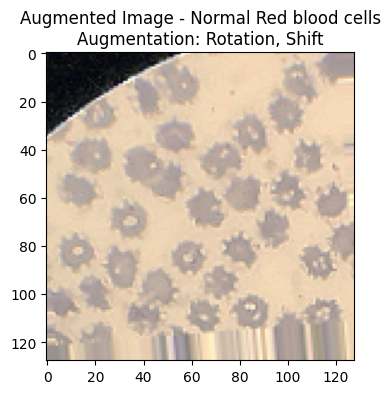

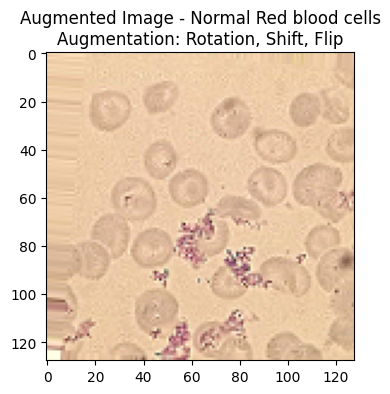

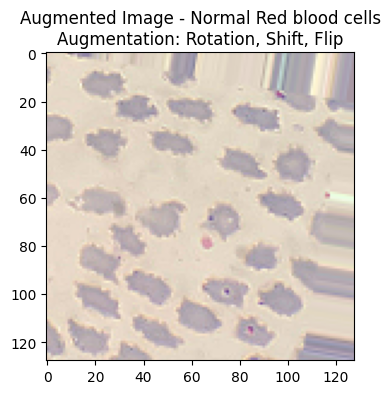

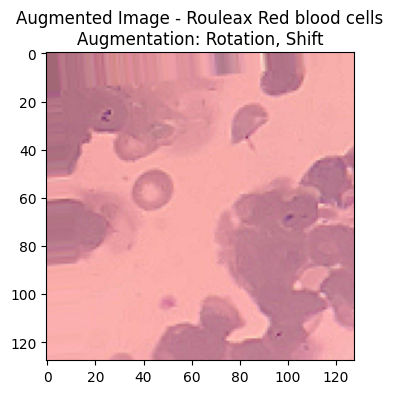

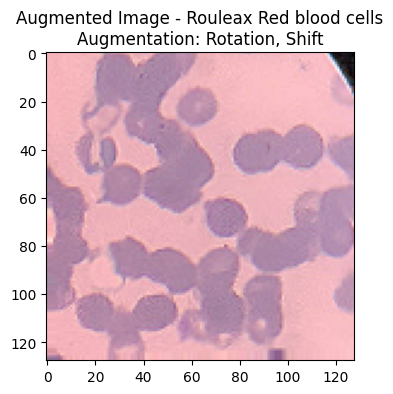

In [31]:
display_augmented_images(augmented_data, label_map)

In [32]:
# Convert to numpy arrays for training
augmented_images = []
augmented_labels = []
for images, labels, _ in augmented_data:  # Unpack the third value but ignore it with `_`
    augmented_images.append(images.numpy())
    augmented_labels.append(labels.numpy())

augmented_images = np.concatenate(augmented_images, axis=0)
augmented_labels = np.concatenate(augmented_labels, axis=0)


In [33]:
y = tf.keras.utils.to_categorical(augmented_labels, num_classes=len(class_names))

In [34]:
X_train_val, X_test, y_train_val, y_test = model_selection.train_test_split(
    augmented_images, y, test_size=0.2, random_state=3, stratify=y)

X_train, X_val, y_train, y_val = model_selection.train_test_split(
    X_train_val, y_train_val, test_size=0.15, random_state=3, stratify=y_train_val)

In [35]:
# Define the DiffusionLayer
class DiffusionLayer(tf.keras.layers.Layer):
    def __init__(self, num_steps=10, beta=0.01, **kwargs):
        super(DiffusionLayer, self).__init__(**kwargs)
        self.num_steps = num_steps
        self.beta = beta

    def diffusion_step(self, image):
        noise = tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=1.0)
        return tf.sqrt(1 - self.beta) * image + tf.sqrt(self.beta) * noise

    def reverse_diffusion_step(self, image):
        return (image - tf.sqrt(self.beta) * tf.random.normal(shape=tf.shape(image), mean=0.0, stddev=1.0)) / tf.sqrt(1 - self.beta)

    def call(self, inputs):
        x = inputs
        for _ in range(self.num_steps):
            x = self.diffusion_step(x)
            x = self.reverse_diffusion_step(x)
        return x


In [36]:
# Kolmogorov-Arnold Network function
def kolmogorov_arnold_network(input_tensor, num_neurons, num_classes):
    F_list = []
    for i in range(num_classes):
        F_i = Dense(num_neurons, activation='relu', kernel_regularizer=l2(1e-4))(input_tensor)
        F_i = Dense(1, use_bias=False, kernel_regularizer=l2(1e-4))(F_i)
        F_list.append(F_i)

    G = Concatenate()(F_list)
    output = Dense(num_classes, activation=None, use_bias=False, kernel_regularizer=l2(1e-4))(G)

    return output


In [18]:
import time
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, Callback

# ======================================================================
# Custom Callback to Track Training Time
# ======================================================================
class TimeTracker(Callback):
    def on_train_begin(self, logs=None):
        self.epoch_times = []
    
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start = time.time()
    
    def on_epoch_end(self, epoch, logs=None):
        self.epoch_times.append(time.time() - self.epoch_start)

time_tracker = TimeTracker()
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# ======================================================================
# Model Architecture (Your Existing Code)
# ======================================================================
input_shape = X_train.shape[1:]
input_img = Input(shape=input_shape)
diffused_img = DiffusionLayer(num_steps=10, beta=0.01)(input_img)

base_model = VGG16(include_top=False, input_shape=input_shape)
for layer in base_model.layers:
    layer.trainable = False

vgg_features = base_model(diffused_img)
flattened_features = Flatten()(vgg_features)
flattened_features = Dropout(0.5)(flattened_features)

kan_output = kolmogorov_arnold_network(flattened_features, num_neurons=1024, num_classes=len(class_names))
kan_output = Dropout(0.5)(kan_output)
output = Dense(len(class_names), activation='softmax')(kan_output)

model = Model(inputs=input_img, outputs=output)
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# ======================================================================
# Train Model with Time Tracking
# ======================================================================
start_train_time = time.time()
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stopping, time_tracker]  # Added time_tracker here
)
total_train_time = time.time() - start_train_time

# ======================================================================
# Calculate Metrics
# ======================================================================
# 1. Training Time Analysis
print(f"\nTotal Training Time: {total_train_time:.2f} seconds")
print(f"Average Time per Epoch: {np.mean(time_tracker.epoch_times):.2f} seconds")

# 2. Inference Time
# Warm-up GPU
dummy_input = np.random.randn(1, *input_shape)
_ = model.predict(dummy_input)

# Single sample inference
start_time = time.time()
_ = model.predict(dummy_input)
single_inference_time = time.time() - start_time
print(f"\nInference Time (Single Sample): {single_inference_time:.4f} seconds")

# Batch inference (using test data)
batch_size = 32
test_batch = X_test[:batch_size]

start_time = time.time()
_ = model.predict(test_batch)
batch_inference_time = time.time() - start_time
avg_inference_time = batch_inference_time / batch_size
print(f"Average Inference Time per Sample (Batch): {avg_inference_time:.4f} seconds")


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30


I0000 00:00:1743433810.349088     108 service.cc:145] XLA service 0x7dc14c010210 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1743433810.349162     108 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1743433810.349169     108 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  2/130 ━━━━━━━━━━━━━━━━━━━━ 9s 78ms/step - accuracy: 0.3906 - loss: 69.2919  

I0000 00:00:1743433825.693271     108 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


130/130 ━━━━━━━━━━━━━━━━━━━━ 55s 292ms/step - accuracy: 0.6088 - loss: 33.6615 - val_accuracy: 0.9398 - val_loss: 0.7069
Epoch 2/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - accuracy: 0.7373 - loss: 1.6016 - val_accuracy: 0.9207 - val_loss: 0.7779
Epoch 3/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.7738 - loss: 1.1098 - val_accuracy: 0.9453 - val_loss: 0.4959
Epoch 4/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.7912 - loss: 0.8088 - val_accuracy: 0.9549 - val_loss: 0.4685
Epoch 5/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.8131 - loss: 0.7842 - val_accuracy: 0.9685 - val_loss: 0.4038
Epoch 6/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.7933 - loss: 0.6909 - val_accuracy: 0.9699 - val_loss: 0.4143
Epoch 7/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - accuracy: 0.8258 - loss: 0.6876 - val_accuracy: 0.9357 - val_loss: 0.4527
Epoch 8/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - accuracy: 0.8181 - loss: 0.6456 - val_accuracy: 0.


FLOPS per Inference: 10.07 Giga-FLOPs

=========================Options=============================
-max_depth                  10000
-min_bytes                  0
-min_peak_bytes             0
-min_residual_bytes         0
-min_output_bytes           0
-min_micros                 0
-min_accelerator_micros     0
-min_cpu_micros             0
-min_params                 0
-min_float_ops              1
-min_occurrence             0
-step                       -1
-order_by                   float_ops
-account_type_regexes       .*
-start_name_regexes         .*
-trim_name_regexes          
-show_name_regexes          .*
-hide_name_regexes          
-account_displayed_op_only  true
-select                     float_ops
-output                     stdout:

==================Model Analysis Report======================

Doc:
scope: The nodes in the model graph are organized by their names, which is hierarchical like filesystem.
flops: Number of float operations. Note: Please read the implem

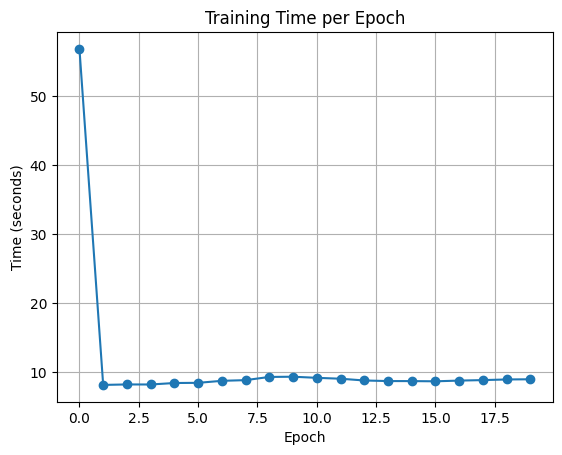

In [19]:
# ======================================================================
# FLOPs Calculation (Alternative Method)
# ======================================================================
def get_model_flops(model):
    @tf.function
    def test_fn(x):
        return model(x)
    
    concrete_fn = test_fn.get_concrete_function(tf.TensorSpec([1, *input_shape]))
    graph = concrete_fn.graph
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
    flops = tf.compat.v1.profiler.profile(graph, options=opts)
    return flops.total_float_ops

try:
    flops = get_model_flops(model)
    print(f"\nFLOPS per Inference: {flops / 1e9:.2f} Giga-FLOPs")
except Exception as e:
    print(f"FLOPs calculation failed: {str(e)}")
# ======================================================================
# Visualization
# ======================================================================
plt.plot(time_tracker.epoch_times, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Time (seconds)')
plt.title('Training Time per Epoch')
plt.grid(True)
plt.show()

In [20]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ diffusion_layer     │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│ (DiffusionLayer)    │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 4, 4, 512) │ 14,714,688 │ diffusion_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 8192)      │          0 │ vgg16[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 8192)      │          0 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1024)      │  8,389,632 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1024)      │  8,389,632 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │      1,024 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │      1,024 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 2)         │          0 │ dense_1[0][0],    │
│ (Concatenate)       │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 2)         │          4 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 2)         │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 2)         │          6 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 65,058,656 (248.18 MB)

 Trainable params: 16,781,322 (64.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

 Optimizer params: 33,562,646 (128.03 MB)

In [21]:
# Evaluate the model
loss, acc = model.evaluate(X_test, y_test)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {acc}")

39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 279ms/step - accuracy: 0.9614 - loss: 0.3791
Test Loss: 0.4029381275177002
Test Accuracy: 0.9556650519371033


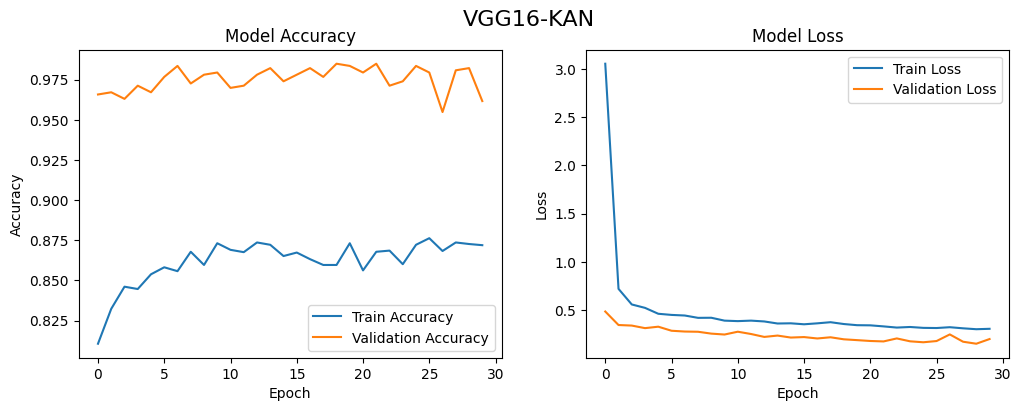

In [26]:
# To visualize the loss and accuracy graphs
def plot_training_history(history):
    # Summarize history for accuracy
    plt.figure(figsize=(12, 4))
    plt.suptitle('VGG16-KAN', fontsize=16)
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    
    plt.show()

# Call the function to plot
plot_training_history(history)

39/39 ━━━━━━━━━━━━━━━━━━━━ 15s 235ms/step
                         precision    recall  f1-score   support

 Normal Red blood cells     0.9800    0.9672    0.9736       609
Rouleax Red blood cells     0.9676    0.9803    0.9739       609

               accuracy                         0.9737      1218
              macro avg     0.9738    0.9737    0.9737      1218
           weighted avg     0.9738    0.9737    0.9737      1218



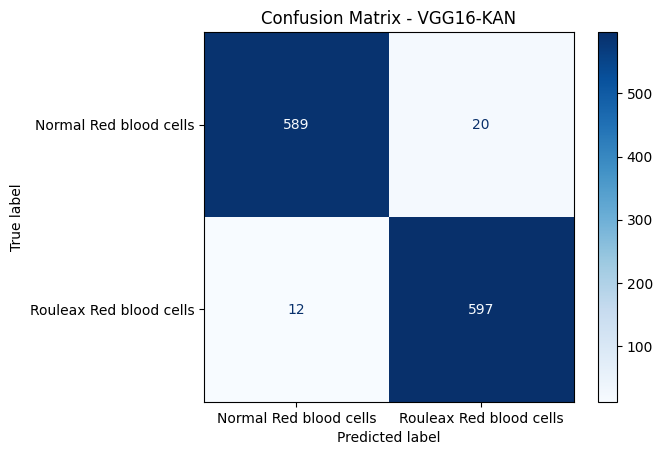

In [27]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Predict on the test set
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report for precision, recall, and F1-score
class_report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print(class_report)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix as an image
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - VGG16-KAN')
plt.show()


Epoch 1/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 45s 254ms/step - accuracy: 0.7451 - loss: 16.2885 - val_accuracy: 0.9248 - val_loss: 1.8173
Epoch 2/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.8351 - loss: 1.7206 - val_accuracy: 0.9425 - val_loss: 1.0191
Epoch 3/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.8313 - loss: 1.3217 - val_accuracy: 0.9384 - val_loss: 1.0744
Epoch 4/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.8449 - loss: 0.9125 - val_accuracy: 0.9398 - val_loss: 1.1331
Epoch 5/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - accuracy: 0.8449 - loss: 0.7626 - val_accuracy: 0.9398 - val_loss: 0.8748
Epoch 6/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 11s 84ms/step - accuracy: 0.8576 - loss: 0.7632 - val_accuracy: 0.9371 - val_loss: 0.8451
Epoch 7/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 81ms/step - accuracy: 0.8643 - loss: 0.7197 - val_accuracy: 0.9466 - val_loss: 0.7676
Epoch 8/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 10s 78ms/step - accuracy: 0.8461 - loss: 0.8042 

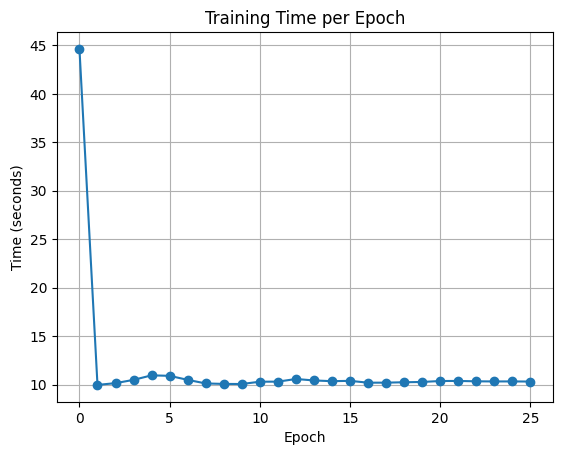

39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 243ms/step - accuracy: 0.9522 - loss: 0.6222

Test Loss: 0.6575190424919128
Test Accuracy: 0.9499179124832153


In [23]:
import time
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, Callback

# ======================================================================
# Custom Callback to Track Training Time
# ======================================================================
class TimeTracker(Callback):
    def on_train_begin(self, logs=None):
        self.epoch_times = []
    
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start = time.time()
    
    def on_epoch_end(self, epoch, logs=None):
        self.epoch_times.append(time.time() - self.epoch_start)

time_tracker = TimeTracker()
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# ======================================================================
# Model Architecture (Your Existing Code)
# ======================================================================
from tensorflow.keras.applications import VGG19

# Define model architecture
input_shape = X_train.shape[1:]
input_img = Input(shape=input_shape)
diffused_img = DiffusionLayer(num_steps=10, beta=0.01)(input_img)

# Replace VGG16 with VGG19
base_model = VGG19(include_top=False, input_shape=input_shape)
for layer in base_model.layers:
    layer.trainable = False

vgg_features = base_model(diffused_img)

flattened_features = Flatten()(vgg_features)
flattened_features = Dropout(0.5)(flattened_features)

kan_output = kolmogorov_arnold_network(flattened_features, num_neurons=1024, num_classes=len(class_names))
kan_output = Dropout(0.5)(kan_output)

output = Dense(len(class_names), activation='softmax')(kan_output)

model = Model(inputs=input_img, outputs=output)
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
# ======================================================================
# Train Model with Time Tracking
# ======================================================================
start_train_time = time.time()
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stopping, time_tracker]  # Added time_tracker here
)
total_train_time = time.time() - start_train_time

# ======================================================================
# Calculate Metrics
# ======================================================================
# 1. Training Time Analysis
print(f"\nTotal Training Time: {total_train_time:.2f} seconds")
print(f"Average Time per Epoch: {np.mean(time_tracker.epoch_times):.2f} seconds")

# 2. Inference Time
# Warm-up GPU
dummy_input = np.random.randn(1, *input_shape)
_ = model.predict(dummy_input)

# Single sample inference
start_time = time.time()
_ = model.predict(dummy_input)
single_inference_time = time.time() - start_time
print(f"\nInference Time (Single Sample): {single_inference_time:.4f} seconds")

# Batch inference (using test data)
batch_size = 32
test_batch = X_test[:batch_size]

start_time = time.time()
_ = model.predict(test_batch)
batch_inference_time = time.time() - start_time
avg_inference_time = batch_inference_time / batch_size
print(f"Average Inference Time per Sample (Batch): {avg_inference_time:.4f} seconds")

# ======================================================================
# FLOPs Calculation (Alternative Method)
# ======================================================================
def get_model_flops(model):
    @tf.function
    def test_fn(x):
        return model(x)
    
    concrete_fn = test_fn.get_concrete_function(tf.TensorSpec([1, *input_shape]))
    graph = concrete_fn.graph
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
    flops = tf.compat.v1.profiler.profile(graph, options=opts)
    return flops.total_float_ops

try:
    flops = get_model_flops(model)
    print(f"\nFLOPS per Inference: {flops / 1e9:.2f} Giga-FLOPs")
except Exception as e:
    print(f"FLOPs calculation failed: {str(e)}")

# ======================================================================
# Visualization
# ======================================================================
plt.plot(time_tracker.epoch_times, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Time (seconds)')
plt.title('Training Time per Epoch')
plt.grid(True)
plt.show()

# ======================================================================
# Original Evaluation Code
# ======================================================================
loss, acc = model.evaluate(X_test, y_test)
print(f"\nTest Loss: {loss}")
print(f"Test Accuracy: {acc}")

In [27]:
model.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ diffusion_layer_6   │ (None, 128, 128,  │          0 │ input_layer_7[0]… │
│ (DiffusionLayer)    │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg19 (Functional)  │ (None, 4, 4, 512) │ 20,024,384 │ diffusion_layer_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 8192)      │          0 │ vgg19[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 8192)      │          0 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 1024)      │  8,389,632 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1024)      │  8,389,632 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 1)         │      1,024 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │      1,024 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 2)         │          0 │ dense_7[0][0],    │
│ (Concatenate)       │                   │            │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 2)         │          4 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 2)         │          0 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 2)         │          6 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 36,805,706 (140.40 MB)

 Trainable params: 16,781,322 (64.02 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [29]:
# Evaluate the model
loss, acc = model.evaluate(X_test, y_test)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {acc}")

39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 262ms/step - accuracy: 0.9742 - loss: 0.3710
Test Loss: 0.36497679352760315
Test Accuracy: 0.9720853567123413


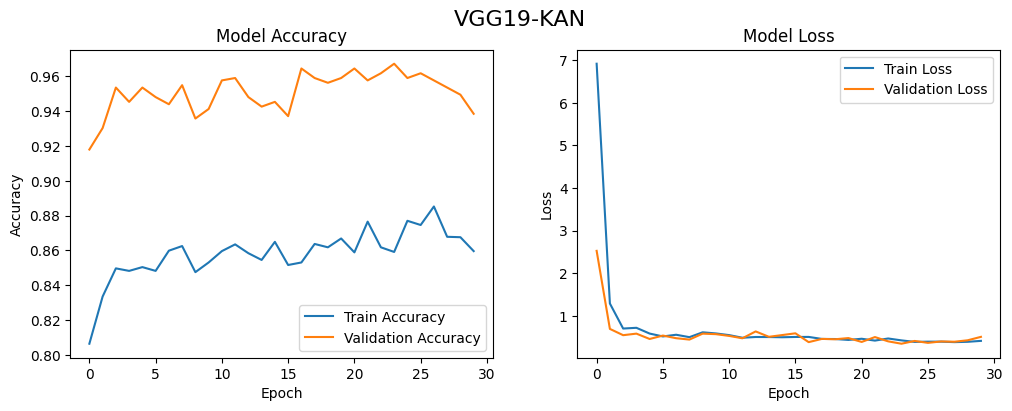

In [30]:
# To visualize the loss and accuracy graphs
def plot_training_history(history):
    # Summarize history for accuracy
    plt.figure(figsize=(12, 4))
    plt.suptitle('VGG19-KAN', fontsize=16)
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    
    plt.show()

# Call the function to plot
plot_training_history(history)

39/39 ━━━━━━━━━━━━━━━━━━━━ 17s 268ms/step
                         precision    recall  f1-score   support

 Normal Red blood cells     0.9721    0.9721    0.9721       609
Rouleax Red blood cells     0.9721    0.9721    0.9721       609

               accuracy                         0.9721      1218
              macro avg     0.9721    0.9721    0.9721      1218
           weighted avg     0.9721    0.9721    0.9721      1218



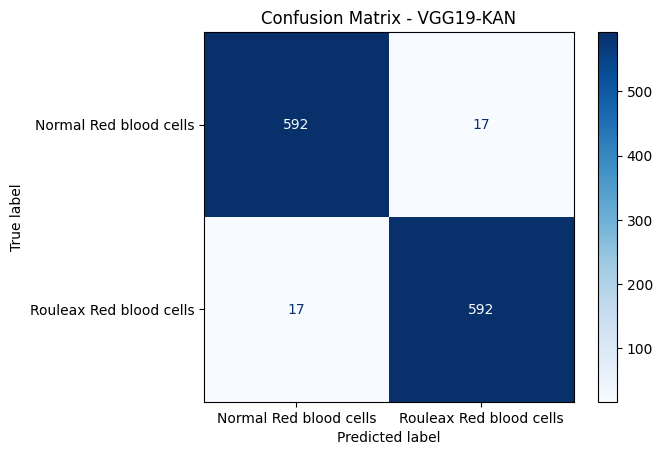

In [31]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Predict on the test set
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report for precision, recall, and F1-score
class_report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print(class_report)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix as an image
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - VGG19-KAN')
plt.show()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 63s 317ms/step - accuracy: 0.5510 - loss: 6.0406 - val_accuracy: 0.9617 - val_loss: 0.7936
Epoch 2/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.6554 - loss: 0.8169 - val_accuracy: 0.9603 - val_loss: 0.4836
Epoch 3/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.7892 - loss: 0.5746 - val_accuracy: 0.9562 - val_loss: 0.3087
Epoch 4/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.8192 - loss: 0.4909 - val_accuracy: 0.9672 - val_loss: 0.2504
Epoch 5/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.8357 - loss: 0.4303 - val_accuracy: 0.9644 - val_loss: 0.2201
Epoch 6/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 67ms/step - accuracy: 0.8532 - loss: 0.3943 - val_accuracy: 0.9644 - val_loss: 0.2052
Epoch 7/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.8601 - loss: 0.3389 - val_accuracy: 0.9699 - val_loss: 0.1850
Epoch 8/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 9s 6

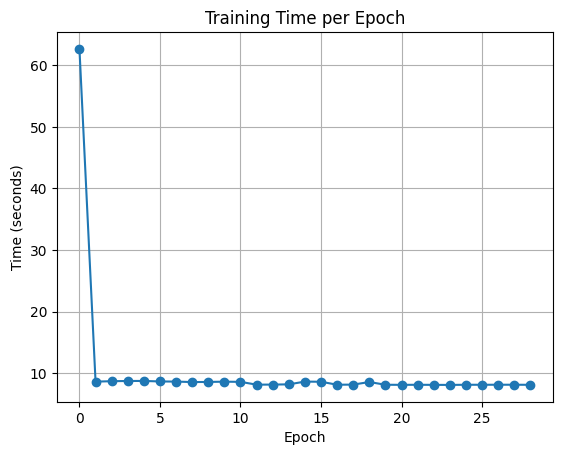

39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 279ms/step - accuracy: 0.9721 - loss: 0.1033

Test Loss: 0.13428127765655518
Test Accuracy: 0.9688013195991516


In [24]:
import time
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, Callback

# ======================================================================
# Custom Callback to Track Training Time
# ======================================================================
class TimeTracker(Callback):
    def on_train_begin(self, logs=None):
        self.epoch_times = []
    
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start = time.time()
    
    def on_epoch_end(self, epoch, logs=None):
        self.epoch_times.append(time.time() - self.epoch_start)

time_tracker = TimeTracker()
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# ======================================================================
# Model Architecture (Your Existing Code)
# ======================================================================
from tensorflow.keras.applications import ResNet50

# Define model architecture
input_shape = X_train.shape[1:]
input_img = Input(shape=input_shape)
diffused_img = DiffusionLayer(num_steps=10, beta=0.01)(input_img)

# Replace VGG19 with ResNet50
base_model = ResNet50(include_top=False, input_shape=input_shape)
for layer in base_model.layers:
    layer.trainable = False

resnet_features = base_model(diffused_img)

flattened_features = Flatten()(resnet_features)
flattened_features = Dropout(0.5)(flattened_features)

kan_output = kolmogorov_arnold_network(flattened_features, num_neurons=1024, num_classes=len(class_names))
kan_output = Dropout(0.5)(kan_output)

output = Dense(len(class_names), activation='softmax')(kan_output)

model = Model(inputs=input_img, outputs=output)
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
# ======================================================================
# Train Model with Time Tracking
# ======================================================================
start_train_time = time.time()
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stopping, time_tracker]  # Added time_tracker here
)
total_train_time = time.time() - start_train_time

# ======================================================================
# Calculate Metrics
# ======================================================================
# 1. Training Time Analysis
print(f"\nTotal Training Time: {total_train_time:.2f} seconds")
print(f"Average Time per Epoch: {np.mean(time_tracker.epoch_times):.2f} seconds")

# 2. Inference Time
# Warm-up GPU
dummy_input = np.random.randn(1, *input_shape)
_ = model.predict(dummy_input)

# Single sample inference
start_time = time.time()
_ = model.predict(dummy_input)
single_inference_time = time.time() - start_time
print(f"\nInference Time (Single Sample): {single_inference_time:.4f} seconds")

# Batch inference (using test data)
batch_size = 32
test_batch = X_test[:batch_size]

start_time = time.time()
_ = model.predict(test_batch)
batch_inference_time = time.time() - start_time
avg_inference_time = batch_inference_time / batch_size
print(f"Average Inference Time per Sample (Batch): {avg_inference_time:.4f} seconds")

# ======================================================================
# FLOPs Calculation (Alternative Method)
# ======================================================================
def get_model_flops(model):
    @tf.function
    def test_fn(x):
        return model(x)
    
    concrete_fn = test_fn.get_concrete_function(tf.TensorSpec([1, *input_shape]))
    graph = concrete_fn.graph
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
    flops = tf.compat.v1.profiler.profile(graph, options=opts)
    return flops.total_float_ops

try:
    flops = get_model_flops(model)
    print(f"\nFLOPS per Inference: {flops / 1e9:.2f} Giga-FLOPs")
except Exception as e:
    print(f"FLOPs calculation failed: {str(e)}")

# ======================================================================
# Visualization
# ======================================================================
plt.plot(time_tracker.epoch_times, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Time (seconds)')
plt.title('Training Time per Epoch')
plt.grid(True)
plt.show()

# ======================================================================
# Original Evaluation Code
# ======================================================================
loss, acc = model.evaluate(X_test, y_test)
print(f"\nTest Loss: {loss}")
print(f"Test Accuracy: {acc}")

In [36]:
# Evaluate the model
loss, acc = model.evaluate(X_test, y_test)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {acc}")

39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 295ms/step - accuracy: 0.9714 - loss: 0.2611
Test Loss: 0.2769570052623749
Test Accuracy: 0.9655172228813171


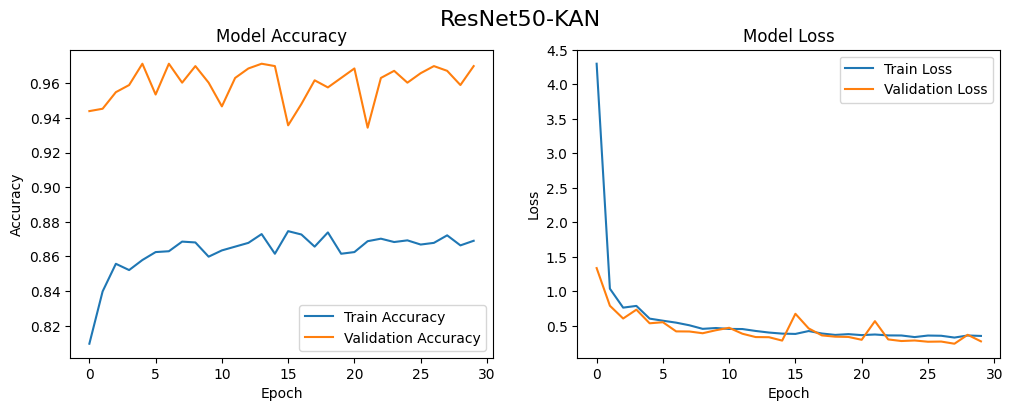

In [37]:
# To visualize the loss and accuracy graphs
def plot_training_history(history):
    # Summarize history for accuracy
    plt.figure(figsize=(12, 4))
    plt.suptitle('ResNet50-KAN', fontsize=16)
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    
    plt.show()

# Call the function to plot
plot_training_history(history)

39/39 ━━━━━━━━━━━━━━━━━━━━ 21s 311ms/step
                         precision    recall  f1-score   support

 Normal Red blood cells     0.9624    0.9672    0.9648       609
Rouleax Red blood cells     0.9670    0.9622    0.9646       609

               accuracy                         0.9647      1218
              macro avg     0.9647    0.9647    0.9647      1218
           weighted avg     0.9647    0.9647    0.9647      1218



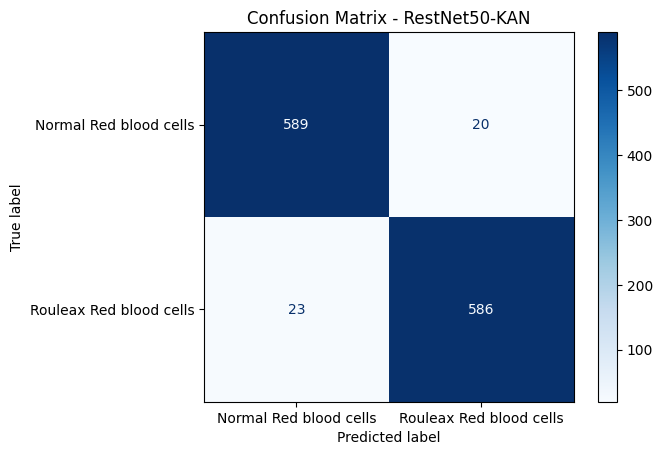

In [38]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Predict on the test set
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report for precision, recall, and F1-score
class_report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print(class_report)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix as an image
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - RestNet50-KAN')
plt.show()


In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, Callback

# ======================================================================
# Custom Callback to Track Training Time
# ======================================================================
class TimeTracker(Callback):
    def on_train_begin(self, logs=None):
        self.epoch_times = []
    
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start = time.time()
    
    def on_epoch_end(self, epoch, logs=None):
        self.epoch_times.append(time.time() - self.epoch_start)

time_tracker = TimeTracker()
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# ======================================================================
# Model Architecture (Your Existing Code)
# ======================================================================
from tensorflow.keras.applications import InceptionV3

# Define model architecture
input_shape = X_train.shape[1:]
input_img = Input(shape=input_shape)
diffused_img = DiffusionLayer(num_steps=10, beta=0.01)(input_img)

# Replace ResNet50 with InceptionV3
base_model = InceptionV3(include_top=False, input_shape=input_shape)
for layer in base_model.layers:
    layer.trainable = False

inception_features = base_model(diffused_img)

flattened_features = Flatten()(inception_features)
flattened_features = Dropout(0.5)(flattened_features)

kan_output = kolmogorov_arnold_network(flattened_features, num_neurons=1024, num_classes=len(class_names))
kan_output = Dropout(0.5)(kan_output)

output = Dense(len(class_names), activation='softmax')(kan_output)

model = Model(inputs=input_img, outputs=output)

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
# ======================================================================
# Train Model with Time Tracking
# ======================================================================
start_train_time = time.time()
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stopping, time_tracker]  # Added time_tracker here
)
total_train_time = time.time() - start_train_time

# ======================================================================
# Calculate Metrics
# ======================================================================
# 1. Training Time Analysis
print(f"\nTotal Training Time: {total_train_time:.2f} seconds")
print(f"Average Time per Epoch: {np.mean(time_tracker.epoch_times):.2f} seconds")

# 2. Inference Time
# Warm-up GPU
dummy_input = np.random.randn(1, *input_shape)
_ = model.predict(dummy_input)

# Single sample inference
start_time = time.time()
_ = model.predict(dummy_input)
single_inference_time = time.time() - start_time
print(f"\nInference Time (Single Sample): {single_inference_time:.4f} seconds")

# Batch inference (using test data)
batch_size = 32
test_batch = X_test[:batch_size]

start_time = time.time()
_ = model.predict(test_batch)
batch_inference_time = time.time() - start_time
avg_inference_time = batch_inference_time / batch_size
print(f"Average Inference Time per Sample (Batch): {avg_inference_time:.4f} seconds")

# ======================================================================
# FLOPs Calculation (Alternative Method)
# ======================================================================
def get_model_flops(model):
    @tf.function
    def test_fn(x):
        return model(x)
    
    concrete_fn = test_fn.get_concrete_function(tf.TensorSpec([1, *input_shape]))
    graph = concrete_fn.graph
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
    flops = tf.compat.v1.profiler.profile(graph, options=opts)
    return flops.total_float_ops

try:
    flops = get_model_flops(model)
    print(f"\nFLOPS per Inference: {flops / 1e9:.2f} Giga-FLOPs")
except Exception as e:
    print(f"FLOPs calculation failed: {str(e)}")

# ======================================================================
# Visualization
# ======================================================================
plt.plot(time_tracker.epoch_times, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Time (seconds)')
plt.title('Training Time per Epoch')
plt.grid(True)
plt.show()

# ======================================================================
# Original Evaluation Code
# ======================================================================
loss, acc = model.evaluate(X_test, y_test)
print(f"\nTest Loss: {loss}")
print(f"Test Accuracy: {acc}")

Epoch 1/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 60s 299ms/step - accuracy: 0.5417 - loss: 202.2174 - val_accuracy: 0.7387 - val_loss: 1.0894
Epoch 2/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.6339 - loss: 1.9896 - val_accuracy: 0.6703 - val_loss: 1.3435
Epoch 3/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.6580 - loss: 1.4578 - val_accuracy: 0.7579 - val_loss: 0.8057
Epoch 4/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.6717 - loss: 1.0379 - val_accuracy: 0.7921 - val_loss: 0.7681
Epoch 5/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.6732 - loss: 0.9038 - val_accuracy: 0.7456 - val_loss: 0.7893
Epoch 6/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.6886 - loss: 0.8667 - val_accuracy: 0.8098 - val_loss: 0.7391
Epoch 7/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.7064 - loss: 0.8506 - val_accuracy: 0.8276 - val_loss: 0.7229
Epoch 8/30
130/130 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.7142 - loss: 0.8013 - val_

In [43]:
# Evaluate the model
loss, acc = model.evaluate(X_test, y_test)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {acc}")

39/39 ━━━━━━━━━━━━━━━━━━━━ 13s 328ms/step - accuracy: 0.8393 - loss: 0.4936
Test Loss: 0.5043497085571289
Test Accuracy: 0.831691324710846


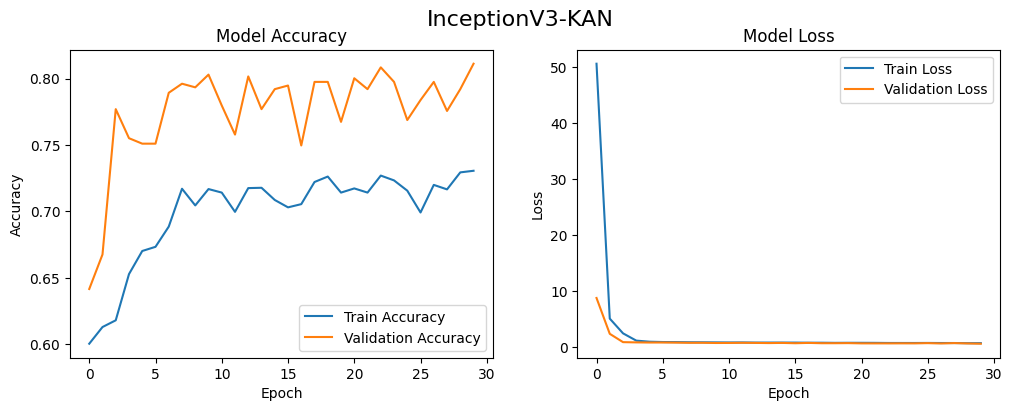

In [44]:
# To visualize the loss and accuracy graphs
def plot_training_history(history):
    # Summarize history for accuracy
    plt.figure(figsize=(12, 4))
    plt.suptitle('InceptionV3-KAN', fontsize=16)
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    
    plt.show()

# Call the function to plot
plot_training_history(history)

39/39 ━━━━━━━━━━━━━━━━━━━━ 24s 348ms/step
                         precision    recall  f1-score   support

 Normal Red blood cells     0.8153    0.8555    0.8349       609
Rouleax Red blood cells     0.8480    0.8062    0.8266       609

               accuracy                         0.8309      1218
              macro avg     0.8317    0.8309    0.8308      1218
           weighted avg     0.8317    0.8309    0.8308      1218



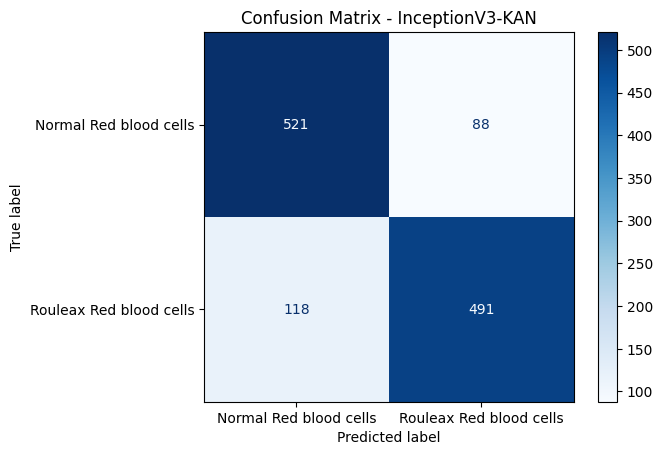

In [45]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Predict on the test set
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report for precision, recall, and F1-score
class_report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print(class_report)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix as an image
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - InceptionV3-KAN')
plt.show()


In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, Callback

# ======================================================================
# Custom Callback to Track Training Time
# ======================================================================
class TimeTracker(Callback):
    def on_train_begin(self, logs=None):
        self.epoch_times = []
    
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start = time.time()
    
    def on_epoch_end(self, epoch, logs=None):
        self.epoch_times.append(time.time() - self.epoch_start)

time_tracker = TimeTracker()
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# ======================================================================
# Model Architecture (Your Existing Code)
# ======================================================================
from tensorflow.keras.applications import MobileNet

# Define model architecture
input_shape = X_train.shape[1:]
input_img = Input(shape=input_shape)
diffused_img = DiffusionLayer(num_steps=10, beta=0.01)(input_img)

# Replace InceptionV3 with MobileNet
base_model = MobileNet(include_top=False, input_shape=input_shape)
for layer in base_model.layers:
    layer.trainable = False

mobilenet_features = base_model(diffused_img)

flattened_features = Flatten()(mobilenet_features)
flattened_features = Dropout(0.5)(flattened_features)

kan_output = kolmogorov_arnold_network(flattened_features, num_neurons=1024, num_classes=len(class_names))
kan_output = Dropout(0.5)(kan_output)

output = Dense(len(class_names), activation='softmax')(kan_output)

model = Model(inputs=input_img, outputs=output)
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
# ======================================================================
# Train Model with Time Tracking
# ======================================================================
start_train_time = time.time()
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stopping, time_tracker]  # Added time_tracker here
)
total_train_time = time.time() - start_train_time

# ======================================================================
# Calculate Metrics
# ======================================================================
# 1. Training Time Analysis
print(f"\nTotal Training Time: {total_train_time:.2f} seconds")
print(f"Average Time per Epoch: {np.mean(time_tracker.epoch_times):.2f} seconds")

# 2. Inference Time
# Warm-up GPU
dummy_input = np.random.randn(1, *input_shape)
_ = model.predict(dummy_input)

# Single sample inference
start_time = time.time()
_ = model.predict(dummy_input)
single_inference_time = time.time() - start_time
print(f"\nInference Time (Single Sample): {single_inference_time:.4f} seconds")

# Batch inference (using test data)
batch_size = 32
test_batch = X_test[:batch_size]

start_time = time.time()
_ = model.predict(test_batch)
batch_inference_time = time.time() - start_time
avg_inference_time = batch_inference_time / batch_size
print(f"Average Inference Time per Sample (Batch): {avg_inference_time:.4f} seconds")

# ======================================================================
# FLOPs Calculation (Alternative Method)
# ======================================================================
def get_model_flops(model):
    @tf.function
    def test_fn(x):
        return model(x)
    
    concrete_fn = test_fn.get_concrete_function(tf.TensorSpec([1, *input_shape]))
    graph = concrete_fn.graph
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
    flops = tf.compat.v1.profiler.profile(graph, options=opts)
    return flops.total_float_ops

try:
    flops = get_model_flops(model)
    print(f"\nFLOPS per Inference: {flops / 1e9:.2f} Giga-FLOPs")
except Exception as e:
    print(f"FLOPs calculation failed: {str(e)}")

# ======================================================================
# Visualization
# ======================================================================
plt.plot(time_tracker.epoch_times, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Time (seconds)')
plt.title('Training Time per Epoch')
plt.grid(True)
plt.show()

# ======================================================================
# Original Evaluation Code
# ======================================================================
loss, acc = model.evaluate(X_test, y_test)
print(f"\nTest Loss: {loss}")
print(f"Test Accuracy: {acc}")

In [50]:
# Evaluate the model
loss, acc = model.evaluate(X_test, y_test)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {acc}")

39/39 ━━━━━━━━━━━━━━━━━━━━ 9s 249ms/step - accuracy: 0.9332 - loss: 0.2315
Test Loss: 0.2608542740345001
Test Accuracy: 0.9154351353645325


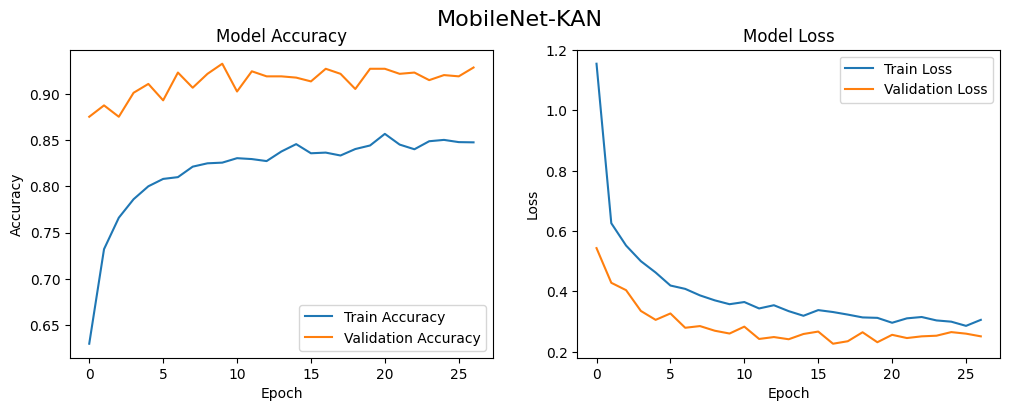

In [51]:
# To visualize the loss and accuracy graphs
def plot_training_history(history):
    # Summarize history for accuracy
    plt.figure(figsize=(12, 4))
    plt.suptitle('MobileNet-KAN', fontsize=16)
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    
    plt.show()

# Call the function to plot
plot_training_history(history)

39/39 ━━━━━━━━━━━━━━━━━━━━ 18s 254ms/step
                         precision    recall  f1-score   support

 Normal Red blood cells     0.9404    0.8801    0.9092       609
Rouleax Red blood cells     0.8873    0.9442    0.9149       609

               accuracy                         0.9122      1218
              macro avg     0.9138    0.9122    0.9121      1218
           weighted avg     0.9138    0.9122    0.9121      1218



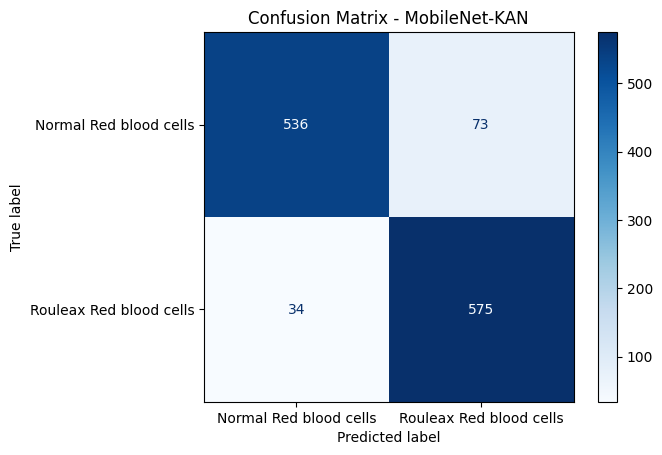

In [52]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Predict on the test set
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report for precision, recall, and F1-score
class_report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print(class_report)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix as an image
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - MobileNet-KAN')
plt.show()


In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, Callback

# ======================================================================
# Custom Callback to Track Training Time
# ======================================================================
class TimeTracker(Callback):
    def on_train_begin(self, logs=None):
        self.epoch_times = []
    
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start = time.time()
    
    def on_epoch_end(self, epoch, logs=None):
        self.epoch_times.append(time.time() - self.epoch_start)

time_tracker = TimeTracker()
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# ======================================================================
# Model Architecture (Your Existing Code)
# ======================================================================
from tensorflow.keras.applications import EfficientNetB0

# Define model architecture
input_shape = X_train.shape[1:]
input_img = Input(shape=input_shape)
diffused_img = DiffusionLayer(num_steps=10, beta=0.01)(input_img)

# Replace MobileNet with EfficientNetB0
base_model = EfficientNetB0(include_top=False, input_shape=input_shape)
for layer in base_model.layers:
    layer.trainable = False

efficientnet_features = base_model(diffused_img)

flattened_features = Flatten()(efficientnet_features)
flattened_features = Dropout(0.5)(flattened_features)

kan_output = kolmogorov_arnold_network(flattened_features, num_neurons=1024, num_classes=len(class_names))
kan_output = Dropout(0.5)(kan_output)

output = Dense(len(class_names), activation='softmax')(kan_output)

model = Model(inputs=input_img, outputs=output)

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
# ======================================================================
# Train Model with Time Tracking
# ======================================================================
start_train_time = time.time()
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stopping, time_tracker]  # Added time_tracker here
)
total_train_time = time.time() - start_train_time

# ======================================================================
# Calculate Metrics
# ======================================================================
# 1. Training Time Analysis
print(f"\nTotal Training Time: {total_train_time:.2f} seconds")
print(f"Average Time per Epoch: {np.mean(time_tracker.epoch_times):.2f} seconds")

# 2. Inference Time
# Warm-up GPU
dummy_input = np.random.randn(1, *input_shape)
_ = model.predict(dummy_input)

# Single sample inference
start_time = time.time()
_ = model.predict(dummy_input)
single_inference_time = time.time() - start_time
print(f"\nInference Time (Single Sample): {single_inference_time:.4f} seconds")

# Batch inference (using test data)
batch_size = 32
test_batch = X_test[:batch_size]

start_time = time.time()
_ = model.predict(test_batch)
batch_inference_time = time.time() - start_time
avg_inference_time = batch_inference_time / batch_size
print(f"Average Inference Time per Sample (Batch): {avg_inference_time:.4f} seconds")

# ======================================================================
# FLOPs Calculation (Alternative Method)
# ======================================================================
def get_model_flops(model):
    @tf.function
    def test_fn(x):
        return model(x)
    
    concrete_fn = test_fn.get_concrete_function(tf.TensorSpec([1, *input_shape]))
    graph = concrete_fn.graph
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
    flops = tf.compat.v1.profiler.profile(graph, options=opts)
    return flops.total_float_ops

try:
    flops = get_model_flops(model)
    print(f"\nFLOPS per Inference: {flops / 1e9:.2f} Giga-FLOPs")
except Exception as e:
    print(f"FLOPs calculation failed: {str(e)}")

# ======================================================================
# Visualization
# ======================================================================
plt.plot(time_tracker.epoch_times, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Time (seconds)')
plt.title('Training Time per Epoch')
plt.grid(True)
plt.show()

# ======================================================================
# Original Evaluation Code
# ======================================================================
loss, acc = model.evaluate(X_test, y_test)
print(f"\nTest Loss: {loss}")
print(f"Test Accuracy: {acc}")

In [57]:
# Evaluate the model
loss, acc = model.evaluate(X_test, y_test)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {acc}")

39/39 ━━━━━━━━━━━━━━━━━━━━ 12s 321ms/step - accuracy: 0.9706 - loss: 0.2161
Test Loss: 0.2193884402513504
Test Accuracy: 0.9655172228813171


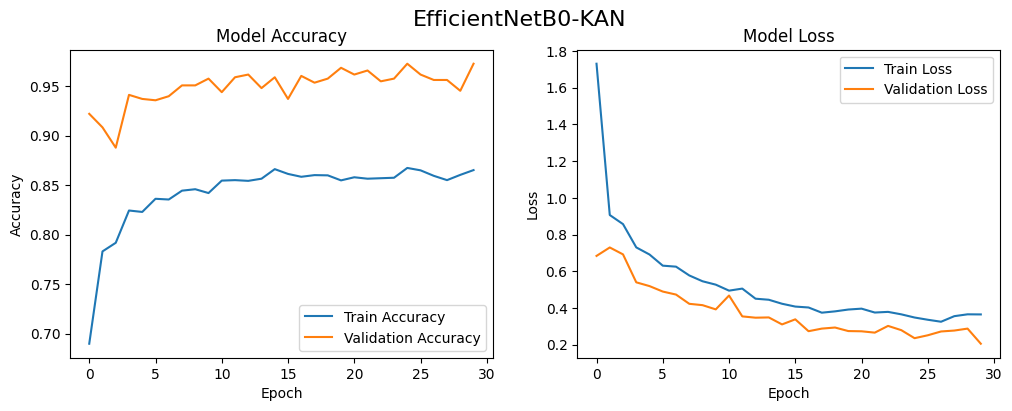

In [58]:
# To visualize the loss and accuracy graphs
def plot_training_history(history):
    # Summarize history for accuracy
    plt.figure(figsize=(12, 4))
    plt.suptitle('EfficientNetB0-KAN', fontsize=16)
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    
    plt.show()

# Call the function to plot
plot_training_history(history)

39/39 ━━━━━━━━━━━━━━━━━━━━ 26s 356ms/step
                         precision    recall  f1-score   support

 Normal Red blood cells     0.9625    0.9688    0.9656       609
Rouleax Red blood cells     0.9686    0.9622    0.9654       609

               accuracy                         0.9655      1218
              macro avg     0.9655    0.9655    0.9655      1218
           weighted avg     0.9655    0.9655    0.9655      1218



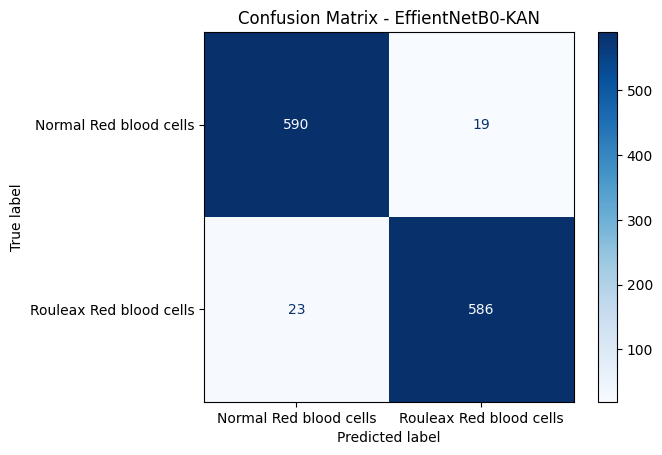

In [59]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Predict on the test set
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report for precision, recall, and F1-score
class_report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print(class_report)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix as an image
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - EffientNetB0-KAN')
plt.show()


In [ ]:
import time
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, Callback

# ======================================================================
# Custom Callback to Track Training Time
# ======================================================================
class TimeTracker(Callback):
    def on_train_begin(self, logs=None):
        self.epoch_times = []
    
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start = time.time()
    
    def on_epoch_end(self, epoch, logs=None):
        self.epoch_times.append(time.time() - self.epoch_start)

time_tracker = TimeTracker()
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# ======================================================================
# Model Architecture (Your Existing Code)
# ======================================================================
from tensorflow.keras.applications import Xception

# Define model architecture
input_shape = X_train.shape[1:]
input_img = Input(shape=input_shape)
diffused_img = DiffusionLayer(num_steps=10, beta=0.01)(input_img)

# Replace EfficientNetB3 with Xception
base_model = Xception(include_top=False, input_shape=input_shape)
for layer in base_model.layers:
    layer.trainable = False

xception_features = base_model(diffused_img)

flattened_features = Flatten()(xception_features)
flattened_features = Dropout(0.5)(flattened_features)

kan_output = kolmogorov_arnold_network(flattened_features, num_neurons=1024, num_classes=len(class_names))
kan_output = Dropout(0.5)(kan_output)

output = Dense(len(class_names), activation='softmax')(kan_output)

model = Model(inputs=input_img, outputs=output)


model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
# ======================================================================
# Train Model with Time Tracking
# ======================================================================
start_train_time = time.time()
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[early_stopping, time_tracker]  # Added time_tracker here
)
total_train_time = time.time() - start_train_time

# ======================================================================
# Calculate Metrics
# ======================================================================
# 1. Training Time Analysis
print(f"\nTotal Training Time: {total_train_time:.2f} seconds")
print(f"Average Time per Epoch: {np.mean(time_tracker.epoch_times):.2f} seconds")

# 2. Inference Time
# Warm-up GPU
dummy_input = np.random.randn(1, *input_shape)
_ = model.predict(dummy_input)

# Single sample inference
start_time = time.time()
_ = model.predict(dummy_input)
single_inference_time = time.time() - start_time
print(f"\nInference Time (Single Sample): {single_inference_time:.4f} seconds")

# Batch inference (using test data)
batch_size = 32
test_batch = X_test[:batch_size]

start_time = time.time()
_ = model.predict(test_batch)
batch_inference_time = time.time() - start_time
avg_inference_time = batch_inference_time / batch_size
print(f"Average Inference Time per Sample (Batch): {avg_inference_time:.4f} seconds")

# ======================================================================
# FLOPs Calculation (Alternative Method)
# ======================================================================
def get_model_flops(model):
    @tf.function
    def test_fn(x):
        return model(x)
    
    concrete_fn = test_fn.get_concrete_function(tf.TensorSpec([1, *input_shape]))
    graph = concrete_fn.graph
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
    flops = tf.compat.v1.profiler.profile(graph, options=opts)
    return flops.total_float_ops

try:
    flops = get_model_flops(model)
    print(f"\nFLOPS per Inference: {flops / 1e9:.2f} Giga-FLOPs")
except Exception as e:
    print(f"FLOPs calculation failed: {str(e)}")

# ======================================================================
# Visualization
# ======================================================================
plt.plot(time_tracker.epoch_times, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Time (seconds)')
plt.title('Training Time per Epoch')
plt.grid(True)
plt.show()

# ======================================================================
# Original Evaluation Code
# ======================================================================
loss, acc = model.evaluate(X_test, y_test)
print(f"\nTest Loss: {loss}")
print(f"Test Accuracy: {acc}")

In [64]:
# Evaluate the model
loss, acc = model.evaluate(X_test, y_test)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {acc}")

39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 299ms/step - accuracy: 0.8692 - loss: 0.4348
Test Loss: 0.44055426120758057
Test Accuracy: 0.866174042224884


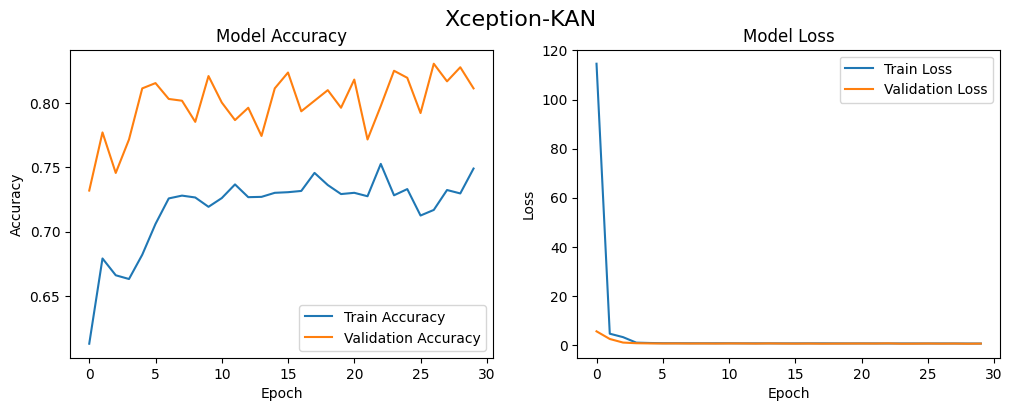

In [65]:
# To visualize the loss and accuracy graphs
def plot_training_history(history):
    # Summarize history for accuracy
    plt.figure(figsize=(12, 4))
    plt.suptitle('Xception-KAN', fontsize=16)
    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    
    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='best')
    
    plt.show()

# Call the function to plot
plot_training_history(history)

39/39 ━━━━━━━━━━━━━━━━━━━━ 20s 297ms/step
                         precision    recall  f1-score   support

 Normal Red blood cells     0.8574    0.8785    0.8678       609
Rouleax Red blood cells     0.8754    0.8539    0.8645       609

               accuracy                         0.8662      1218
              macro avg     0.8664    0.8662    0.8662      1218
           weighted avg     0.8664    0.8662    0.8662      1218



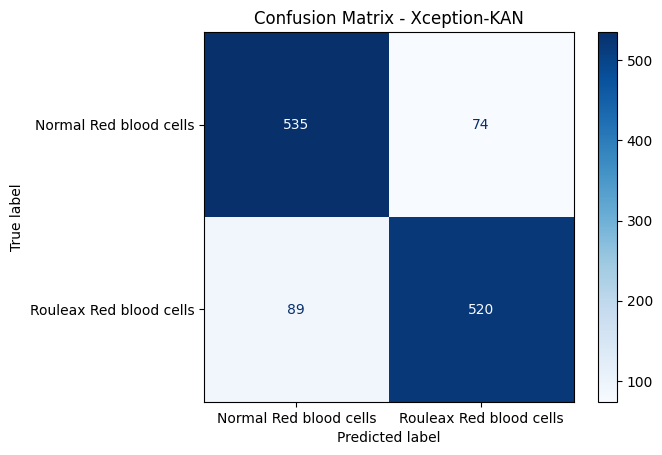

In [66]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Predict on the test set
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_test, axis=1)

# Classification report for precision, recall, and F1-score
class_report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print(class_report)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Display confusion matrix as an image
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Xception-KAN')
plt.show()
